In [183]:
import os.path

import pandas as pd

bench = 'nb101'
suffix = '_full' if bench != 'nb101' and 'macro' not in bench else '_first'
cfg = f'../zc_combine/configs/{bench}{suffix}.json'
dataset = 'cifar10' if bench != 'tnb101' else 'class_scene'

In [184]:
from zc_combine.utils.script_utils import create_cache_filename
from zc_combine.utils.script_utils import load_feature_proxy_dataset

version_key = 'paper'
cache_path = create_cache_filename('../scripts/cache_data/', cfg, None, version_key, True)

_, data, y = load_feature_proxy_dataset('../data', bench, dataset, cfg=cfg, use_all_proxies=True,
                                        cache_path=cache_path, version_key=version_key)

In [185]:
from zc_combine.fixes.operations import get_ops_edges_nb201, get_ops_edges_tnb101, get_ops_nb101

if bench == 'nb201':
    ops, edges = get_ops_edges_nb201()
    names = ('nor_conv_3x3', 'nor_conv_1x1')
elif bench == 'tnb101':    
    ops, edges = get_ops_edges_tnb101()
    names = ('nor_conv_3x3', 'nor_conv_1x1')
elif bench == 'nb101':
    ops = get_ops_nb101()
    names = ('conv3x3-bn-relu', 'conv1x1-bn-relu')
else:
    raise ValueError()

id1, id2 = ops.index(names[0]), ops.index(names[1])
print(names)
print(id1, id2)
data['#convs'] = data[f'op_count_{id1}'] + data[f'op_count_{id2}']

('conv3x3-bn-relu', 'conv1x1-bn-relu')
4 3


In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [187]:
import os

if not os.path.exists('figs'):
    os.mkdir('figs')    

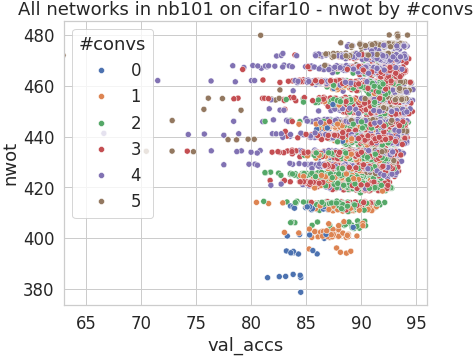

In [188]:
n_palette = len(data['#convs'].unique())

plt.rcParams.update({'text.usetex': False, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 10, 'axes.labelsize': 10, 'legend.fontsize': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.titlesize': 8, 'lines.markersize': 25})
sns.set(font_scale=1.5)# palette=sns.color_palette()[::-1])
sns.set_style('whitegrid')

prox = 'nwot'

plt.figure(figsize=(6,5))
sns.scatterplot(data=data[data[prox] > 0], y=prox, x=y, hue=data['#convs'], palette=sns.color_palette()[:n_palette])

if bench == 'nb201':
    plt.xlim(50, 93)
    pass
elif bench == 'nb101':
    plt.xlim(63, 96)
elif bench == 'tnb101':
    #plt.xlim(10, 58)
    pass
    

plt.title(f'All networks in {bench} on {dataset} - {prox} by #convs')
#plt.tight_layout()
plt.savefig(f'figs/{bench}_{dataset}_{prox}_nconvs_new.png')
plt.show()

/tmp/ipykernel_24121/3469570774.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['#conv3x3'] = data[f'op_count_{id1}']


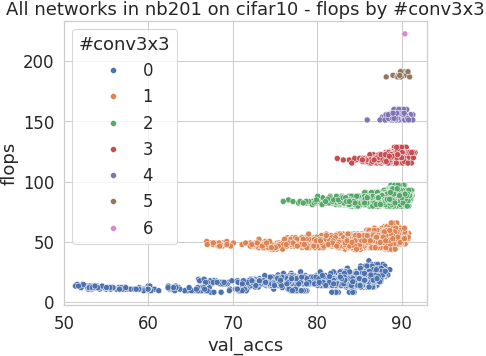

In [163]:
sns.set(font_scale=1.5)# palette=sns.color_palette()[::-1])
sns.set_style('whitegrid')
prox = 'flops'

data['#conv3x3'] = data[f'op_count_{id1}']
n_palette = len(data['#conv3x3'].unique())

plt.figure(figsize=(6, 5))
sns.scatterplot(data=data[data[prox] > 0], y=prox, x=y, hue=data['#conv3x3'], palette=sns.color_palette()[:n_palette])

if bench == 'nb201':
    plt.xlim(50, 93)
elif bench == 'nb101':
    plt.xlim(63, 96)
elif bench == 'tnb101':
    #plt.xlim(10, 58)
    pass

plt.title(f'All networks in {bench} on {dataset} - {prox} by #conv3x3')
#plt.tight_layout()
plt.savefig(f'figs/{bench}_{prox}_n3x3.png')
plt.show()

In [134]:
proxies = [c for c in data.columns if 'op_' not in c and '(' not in c and c not in ['net', '#convs', '#conv3x3']]
print(proxies)

['epe_nas', 'fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'synflow', 'zen']


In [135]:
import scipy.stats
import pandas as pd


compute_tau = False
res_corrs = []

data['#conv3x3'] = data[f'op_count_{id1}']

key = '#convs'

def get_corr(d):
    return {k: func(d[k], y[d.index])[0] for k in proxies}


for nc in sorted(data[key].unique()):    
    filtnets = data[data[key] == nc]
    if len(filtnets) < 2:
        continue
    
    func = scipy.stats.kendalltau if compute_tau else scipy.stats.spearmanr
    
    res = get_corr(filtnets)
    res = {key: nc, **res}
    res_corrs.append(res)
    
res_all = get_corr(data)
res_all = {key: 'all data', **res_all}
res_corrs.append(res_all)

df = pd.DataFrame(res_corrs)
df.T 

,0,1,2,3,4,5,6
#convs,0,1,2,3,4,5,all data
epe_nas,0.211534,0.011499,0.010352,0.020885,-0.003939,-0.003152,-0.009447
fisher,-0.165002,-0.339954,-0.385352,-0.459383,-0.618686,-0.706354,-0.285864
flops,0.65725,0.513131,0.432796,0.33834,0.168698,0.027596,0.377443
grad_norm,0.198278,-0.307568,-0.381206,-0.465095,-0.630064,-0.707247,-0.247164
grasp,-0.414154,0.197203,0.233786,0.20335,0.19676,0.011293,0.265746
jacov,0.169887,0.069771,-0.023839,-0.132539,-0.133494,0.064735,-0.27912
l2_norm,0.759564,0.427305,0.456736,0.411073,0.2512,0.224363,0.495861
nwot,0.680528,0.301112,0.268027,0.236418,0.111575,0.08287,0.311725
params,0.695804,0.530548,0.44894,0.345937,0.170024,0.027241,0.382336


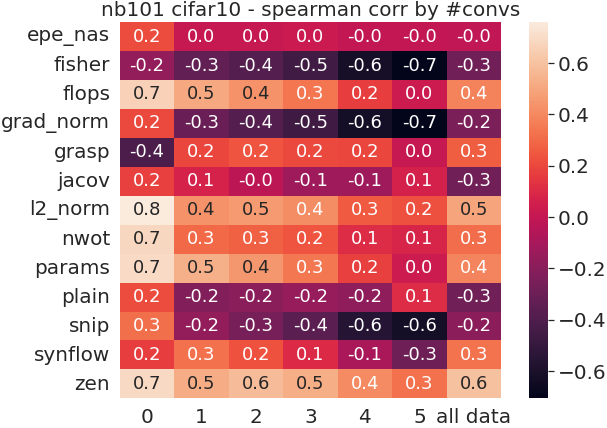

In [136]:
heatdf = df.T
heatdf.rename(columns=heatdf.iloc[0], inplace=True)
heatdf.drop(heatdf.index[0], inplace=True)

sns.set(font_scale=1.3)

plt.rcParams.update({'text.usetex': False, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 18, 'axes.labelsize': 20, 'legend.fontsize': 6, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.titlesize': 20})
#sns.set(font_scale=1.5)# palette=sns.color_palette()[::-1])
sns.set_style('whitegrid')

plt.figure(figsize=(8.5, 6))
sns.heatmap(data=heatdf.astype(float), annot=True, fmt=".1f")
plt.title(f'{bench} {dataset} - spearman corr by {key}')
#plt.tight_layout()
plt.savefig(f'figs/heat_{bench}_{key[1:]}.pdf')
plt.show()

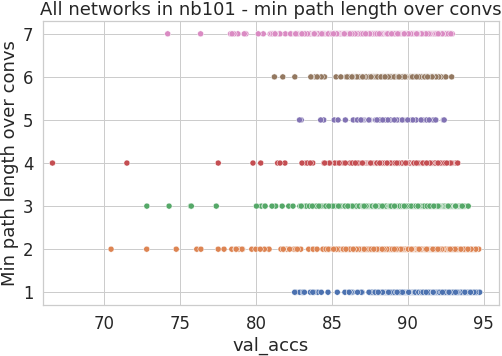

In [140]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=data, y='min_path_len_banned_(2)', x=y, hue='min_path_len_banned_(2)', legend=False, palette=sns.color_palette()[:7])
plt.xlim(66, 96)
plt.title(f'All networks in {bench} - min path length over convs')
plt.ylabel('Min path length over convs')
plt.savefig(f'figs/min_path_{bench}.png')
plt.show()

In [33]:
data.columns

Index(['op_count_0', 'op_count_1', 'op_count_2', 'op_count_3', 'op_count_4',
       'min_path_len_banned_()', 'min_path_len_banned_(2)',
       'min_path_len_banned_(3)', 'min_path_len_banned_(4)',
       'min_path_len_banned_(2, 3)', 'min_path_len_banned_(2, 4)',
       'min_path_len_banned_(3, 4)', 'max_op_on_path_allowed_(2)',
       'max_op_on_path_allowed_(3)', 'max_op_on_path_allowed_(4)',
       'max_op_on_path_allowed_(2, 3)', 'max_op_on_path_allowed_(2, 4)',
       'max_op_on_path_allowed_(3, 4)', 'max_op_on_path_allowed_(2, 3, 4)',
       'node_degree_allowed_(2)_in_degree',
       'node_degree_allowed_(2)_out_degree', 'node_degree_allowed_(2)_avg_in',
       'node_degree_allowed_(2)_avg_out', 'node_degree_allowed_(2)_max_out',
       'node_degree_allowed_(2)_max_in', 'node_degree_allowed_(3)_in_degree',
       'node_degree_allowed_(3)_out_degree', 'node_degree_allowed_(3)_avg_in',
       'node_degree_allowed_(3)_avg_out', 'node_degree_allowed_(3)_max_out',
       'node_degre